In [ ]:
import keras
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
import numpy as np
import pandas as pd
from collections import defaultdict
import re

import sys
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model
# initialising some neural network parameters
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10423980421071706421
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7096108779965017217
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14246275621007142682
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15701463552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6858975889158098425
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6753340928807123850
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16864976920629217534
physical_device_desc: "device: XLA_CPU device"
, name:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# downloading glove pretrained model
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2020-05-06 16:58:49--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-05-06 16:58:50--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-05-06 16:58:50--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!ls
!pwd

drive		   glove.6B.200d.txt  glove.6B.50d.txt	sample_data
glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip
/content


**Cleaning the text**

In [ ]:
import nltk
import regex as re
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Cleaning of dataset
def clean_str(text):
  ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    ## Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return text

In [ ]:
# train data preprocessing
df = pd.read_csv('/content/drive/My Drive/train.csv',sep=',')
df['truth'] = df['truth'].replace('clickbait',1)
df['truth'] = df['truth'].replace('no-clickbait',0)
df['headline'] = df.headline.apply(lambda x : clean_str(x))
texts = []
labels = []

for i in range(df.headline.shape[0]):
    texts.append(df.headline[i])
    labels.append(df.truth[i])

#test data preprocessing
df_test = pd.read_csv('/content/drive/My Drive/test.csv',sep=',')
df_test['truth'] = df_test['truth'].replace('clickbait',1)
df_test['truth'] = df_test['truth'].replace('no-clickbait',0)
df_test['headline'] = df_test.headline.apply(lambda x : clean_str(x))
texts_test = []
labels_test = []


for i in range(df_test.headline.shape[0]):
    texts_test.append(df_test.headline[i])
    labels_test.append(df_test.truth[i])

text=texts+texts_test
# num_words the parameter that controls the number of words in the mapping dictionary known as tokenizer.word_index
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

# where texts contains lists, we assume each entry of the lists to be a token.
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 14890 unique tokens.


In [ ]:
l=df_test['truth'].value_counts()
print("the total dataset size:",len(df_test),'\n',l)

the total dataset size: 6400 
 1    3217
0    3183
Name: truth, dtype: int64


**Since LSTMs and CNNs take inputs of same length and dimension, input images and sequences are padded to maximum length while testing and training**

In [ ]:
# samples that are shorter than the longest item need to be padded with some placeholder value
# doing Padding training sequences
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(labels),num_classes = 2)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (25600, 1000)


In [ ]:
# doing Padding test sequences
sequences_test = tokenizer.texts_to_sequences(texts_test)
data_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
labels_test = to_categorical(np.asarray(labels_test),num_classes = 2)
print('Shape of data tensor:', data_test.shape)

Shape of data tensor: (6400, 1000)


In [ ]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
from matplotlib import pyplot as plt
from keras.layers import Dense, Embedding, LSTM, GRU

%matplotlib inline

In [ ]:

#Using Pre-trained word embeddings (glove)
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove.' % len(embeddings_index))

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
 # The embedding layer encodes the input sequence into a sequence of dense vectors of dimension embed_dim.       
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable = False)

Total 400000 word vectors in Glove.


**LSTM**

In [ ]:
# Dropout is a technique used to prevent a model from overfitting
# A dense layer represents a matrix vector multiplication.The values in the matrix are the trainable parameters which get updated during backpropagation.
# As Sigmoid can output 0 or 1, it can be used to forget or remember the information.
# The sigmoid layer takes the input X(t) and h(t-1)(Output of last LSTM unit) and decides which parts from old output should be removed (by outputting a 0).
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='sigmoid'))
# the optimizer, the loss function, and the metrics of performance.
# The optimizer is the gradient descent algorithm . 
# binary_crossentropy loss function is used since we are doing a binary classification i.e clickbait or no-clickbait
# the metrix we used is for finding accuracy
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         1489100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 1,569,702
Trainable params: 80,602
Non-trainable params: 1,489,100
_________________________________________________________________


In [ ]:
history1=model.fit(data, labels , epochs=20, batch_size=256 ,validation_split=0.2)

Train on 20480 samples, validate on 5120 samples
Epoch 1/20
20480/20480 [==============================] - 126s 6ms/step - loss: 0.4242 - accuracy: 0.8115 - val_loss: 0.2988 - val_accuracy: 0.8734
Epoch 2/20
20480/20480 [==============================] - 123s 6ms/step - loss: 0.3074 - accuracy: 0.8669 - val_loss: 0.2782 - val_accuracy: 0.8850
Epoch 3/20
20480/20480 [==============================] - 123s 6ms/step - loss: 0.2814 - accuracy: 0.8812 - val_loss: 0.2480 - val_accuracy: 0.8965
Epoch 4/20
20480/20480 [==============================] - 122s 6ms/step - loss: 0.2580 - accuracy: 0.8914 - val_loss: 0.2350 - val_accuracy: 0.9004
Epoch 5/20
20480/20480 [==============================] - 123s 6ms/step - loss: 0.2454 - accuracy: 0.8975 - val_loss: 0.2159 - val_accuracy: 0.9078
Epoch 6/20
20480/20480 [==============================] - 124s 6ms/step - loss: 0.2273 - accuracy: 0.9072 - val_loss: 0.2019 - val_accuracy: 0.9159
Epoch 7/20
20480/20480 [==============================] - 125s 

**Initially I trained the model for 30 epochs and drew the graph between loss and no of epochs from seeing the graph i selected no of epochs as 20**

**To finalise the no of epoch I drew a plot between loss and epochs**

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


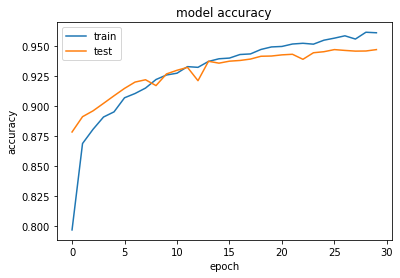

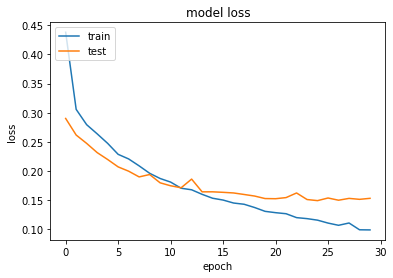

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 
# list all data in history1
print(history1.history.keys())
# summarize history1 for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history1 for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#from below plot we can see that from no of epochs greater than 20 there is no much change in loss of test data so i took no of epochs as 20

In [ ]:
 # Printing Classification report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
x_pred = model.predict(data_test)
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = labels_test.argmax(1)
print(classification_report(y_test_s, x_pred ,target_names = ['clickbait' , 'no-clickbait']))

              precision    recall  f1-score   support

   clickbait       0.94      0.93      0.93      3183
no-clickbait       0.93      0.94      0.93      3217

    accuracy                           0.93      6400
   macro avg       0.93      0.93      0.93      6400
weighted avg       0.93      0.93      0.93      6400



**CNN MODEL**

In [ ]:
# Sequential is used to initialize the neural network.
# Pooling layers provide an approach to down sampling feature maps by summarizing the presence of features in patches of the feature map
# A dense layer represents a matrix vector multiplication.The values in the matrix are the trainable parameters which get updated during backpropagation.
# we apply the rectifier function(relu) to increase non-linearity in the CNN.
# Flattening involves transforming the entire pooled feature map matrix into a single column which is then fed to the neural network for processing.
# After flattening, the flattened feature map is passed through a neural network.
# The final values produced by the neural network don’t usually add up to one
# it is important that these values are brought down to numbers between zero and one, which represent the probability of each class. This is the role of the Softmax function.
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_flat = Flatten()(l_pool1)
l_dense = Dense(32, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)

modell = Model(sequence_input, preds)
# the optimizer, the loss function, and the metrics of performance.
# The optimizer is the gradient descent algorithm . 
# binary_crossentropy loss function is used since we are doing a binary classification i.e clickbait or no-clickbait
# the metrix we used is for finding accuracy
modell.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['acc'])


print("Fitting the simple convolutional neural network model")
modell.summary()
history = modell.fit(data, labels, validation_split=0.2,epochs=10, batch_size=512)

Fitting the simple convolutional neural network model
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 1000, 100)         1489100   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 25472)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                815136    
_________________________________________________________________
dense

**Initially I trained the model for 50 epochs and drew the graph between loss and no of epochs from seeing the graph i selected no of epochs as 10**

**To finalise the no of epoch I drew a plot between loss and epochs**

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


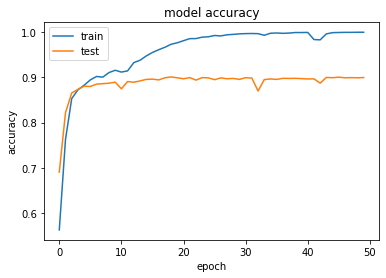

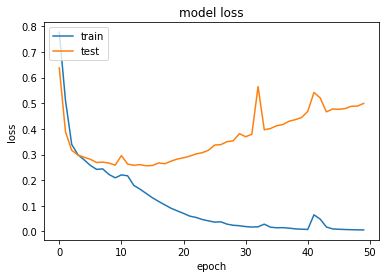

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#from below plot we can see that from no of epochs greater than 10 the moel is going to overfit

In [ ]:
 # Printing Classification report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
x_pred = modell.predict(data_test)
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = labels_test.argmax(1)
print(classification_report(y_test_s, x_pred ,target_names = ['clickbait' , 'no-clickbait']))

              precision    recall  f1-score   support

   clickbait       0.91      0.87      0.89      3183
no-clickbait       0.88      0.91      0.90      3217

    accuracy                           0.89      6400
   macro avg       0.89      0.89      0.89      6400
weighted avg       0.89      0.89      0.89      6400

